In [1]:
import random
import pandas as pd


from tqdm import tqdm
import numpy as np
import lightgbm as lgb
from sklearn import datasets, linear_model

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
TARGET = 'item_id'
SHOW_WIN = 6
PRED_WIN = 3

In [3]:
u_hists = pd.read_csv('./data/train.csv')
u_feats = pd.read_csv('./data/user-features.csv')
sumb = pd.read_csv('./data/sample-submission.csv')

In [4]:
items = u_hists['item_id'].unique()
users = sumb['user_id'].unique()

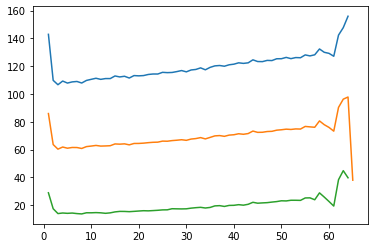

In [5]:
mean = u_hists.groupby('order').mean()['item_id']
std = u_hists.groupby('order').std()['item_id']

plt.plot(mean+std)
plt.plot(mean)
plt.plot(mean-std)

<AxesSubplot:xlabel='dif'>

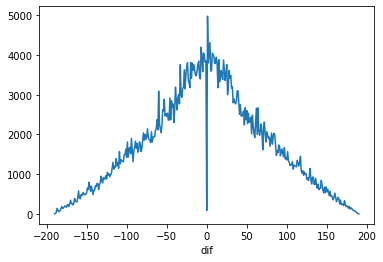

In [51]:
u_hists['dif'] = u_hists['item_id'].diff()

u_hists.dropna().groupby('dif')['user_id'].nunique().plot()

<AxesSubplot:xlabel='dif'>

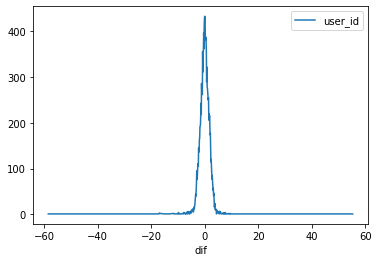

In [69]:
stat = u_hists.dropna().groupby('user_id')['dif'].mean().to_frame().reset_index()
stat['dif'] = np.round(stat['dif'], 1)
stat.groupby('dif').nunique().plot()

<AxesSubplot:xlabel='dif'>

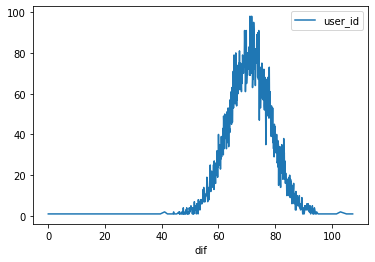

In [86]:
stat = u_hists.dropna().groupby('user_id')['dif'].std().to_frame().reset_index()
stat['dif'] = np.round(stat['dif'], 1)
stat.groupby('dif').nunique().plot()

<AxesSubplot:xlabel='dif'>

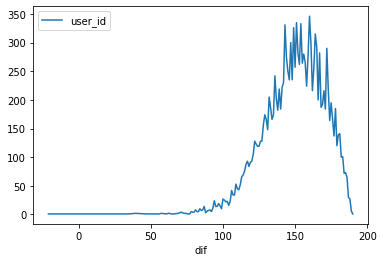

In [87]:
stat = u_hists.dropna().groupby('user_id')['dif'].max().to_frame().reset_index()
stat['dif'] = np.round(stat['dif'], 1)
stat.groupby('dif').nunique().plot()

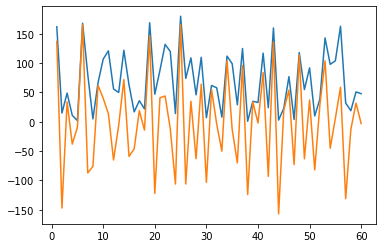

In [114]:
xpl = u_hists.query('user_id == 444')
plt.plot(xpl['order'], xpl['item_id'])
plt.plot(xpl['order'], xpl['dif'])

166.0

In [92]:
for user in tqdm(users[:]):
    old_vals = u_hists.query('user_id == @user').item_id.values
    new_vals = np.array(list(filter(lambda x: x not in old_vals, items)))[:10]
    mask = sorted(random.sample(range(10), 3))
    pred = new_vals[mask]
    sumb.loc[sumb['user_id'] == user, 'item_id'] = pred

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [02:07<00:00, 117.51it/s]


In [93]:
sumb

,user_id,item_id,order
0,0,66,1
1,0,68,2
2,0,73,3
3,1,1,1
4,1,4,2
...,...,...,...
44995,14998,4,2
44996,14998,5,3
44997,14999,4,1
44998,14999,10,2


In [94]:
sumb.to_csv('./data/submission.csv', index=False)

In [6]:
max_ord = u_hists.groupby('user_id')['order'].max().to_frame().reset_index().rename(columns={'order': 'max_ord'})

In [7]:
total_size = SHOW_WIN + PRED_WIN
tr_data = u_hists.merge(max_ord, how='left').query('max_ord >= @total_size')

In [8]:
lr_X = np.ones(SHOW_WIN)
lr_Y = np.ones(PRED_WIN)

for user in tqdm(users[:]):

    trs = tr_data.query('user_id == @user')['item_id'].values

    split = (len(trs) // SHOW_WIN) * SHOW_WIN

    X = trs[:split].reshape(-1, 6)
    ln = len(X)

    if ln == 1:
        trX = X
        trY = trs[split:split+PRED_WIN]
    else:
        trX = X[:len(X)-1]
        trY = X[1:,0:PRED_WIN]
        
    lr_X = np.vstack((lr_X, trX))
    lr_Y = np.vstack((lr_Y, trY))
    
    
lr_X = lr_X[1:]
lr_Y = lr_Y[1:]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:47<00:00, 139.73it/s]
